# This file will contain Graph data and implementations.

In [1]:
import networkx as nx
import pandas as pd
from scipy.spatial import KDTree

In [2]:
import pandas as pd
carrauntoohil_data_set = pd.read_csv('carrauntoohil_data_set.csv')
carrauntoohil_path_data = pd.read_csv('path_terrain_set.csv')
highest = carrauntoohil_data_set['elevation'].max()
print(highest) # Retrieve the highest point in the Data Set
# 51.99895007,-9.74338607,1006.589660644531

1006.589660644531


In [3]:
def return_shortest_path():
  # Import data, combine into one Graph.
  carrauntoohil_data_set = pd.read_csv('carrauntoohil_data_set.csv')
  carrauntoohil_path_data = pd.read_csv('path_terrain_set.csv')
  combined_data_set = pd.concat([carrauntoohil_data_set, carrauntoohil_path_data]).drop_duplicates()
  combined_data_set.to_csv('test.csv')
  G = nx.Graph()
  for _, row in combined_data_set.iterrows():
    G.add_node((row['latitude'], row['longitude']), elevation=row['elevation'])

  # KDTree creates proximity-based edges.
  points = combined_data_set[['latitude', 'longitude']].values
  tree = KDTree(points)
  for i, point in enumerate(points):
    distances, indices = tree.query(point, k=5) # 5 neighbours
    for dist, idx in zip(distances, indices):
      if i != idx:
        G.add_edge( # Add edges based on proximity
          (points[i][0], points[i][1]),
          (points[idx][0], points[idx][1]),
          weight=dist
        )
  # source=(51.99895007, -9.74338607), target=(52.025803, -9.7086641)
  shortest_path = nx.shortest_path(G, source=(51.99895007, -9.74338607), target=(52.025803, -9.7086641), weight='weight')
  return shortest_path
return_shortest_path()

[(51.99895007, -9.74338607),
 (np.float64(51.99903999999999), np.float64(-9.74338607)),
 (np.float64(51.9991543), np.float64(-9.7433791)),
 (np.float64(51.9991849), np.float64(-9.7432476)),
 (np.float64(51.99921986), np.float64(-9.74324)),
 (np.float64(51.99921986), np.float64(-9.74309393)),
 (np.float64(51.9992806), np.float64(-9.7430174)),
 (np.float64(51.99939972), np.float64(-9.74294786)),
 (np.float64(51.99939972), np.float64(-9.74280179)),
 (np.float64(51.9994441), np.float64(-9.742742)),
 (np.float64(51.9994483), np.float64(-9.7426294)),
 (np.float64(51.99948964999999), np.float64(-9.74250965)),
 (np.float64(51.99957958), np.float64(-9.74250965)),
 (np.float64(51.99957958), np.float64(-9.74236358)),
 (np.float64(51.99957958), np.float64(-9.74221751)),
 (np.float64(51.99957958), np.float64(-9.74207144)),
 (np.float64(51.99957958), np.float64(-9.74192537)),
 (np.float64(51.99957958), np.float64(-9.7417793)),
 (np.float64(51.99957958), np.float64(-9.74163323)),
 (np.float64(51.9995

# Display The Final Data Map with MatPlotLib

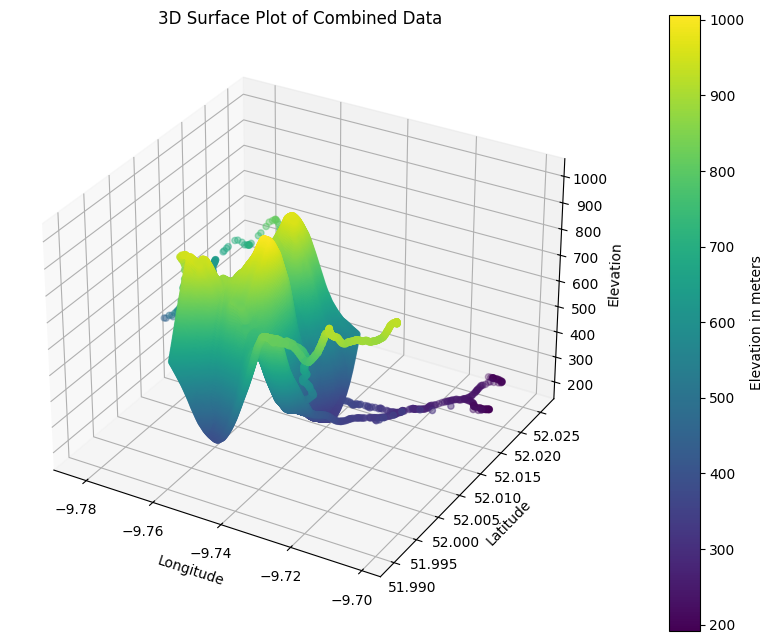

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Load Data Set, extract lats, longs, and elevations.
carrauntoohil_data_set = pd.read_csv('carrauntoohil_data_set.csv')
carrauntoohil_path_data = pd.read_csv('path_terrain_set.csv')
combined_data_set = pd.concat([carrauntoohil_data_set, carrauntoohil_path_data]).drop_duplicates()
latitudes = combined_data_set['latitude'].values
longitudes = combined_data_set['longitude'].values
elevations = combined_data_set['elevation'].values

# surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(longitudes, latitudes, elevations, c=elevations, cmap='viridis', marker='o')
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Elevation in meters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevation')
ax.set_title('3D Surface Plot of Combined Data')
plt.show()

## Implement a Path Finding Algorithm
This algorithm will take the NetworkX A* algorithm as a base, and apply a weighting function to assess the difference in elevation between nodes.

In [5]:
import networkx as nx
import heapq
from haversine import haversine, Unit
def find_path(G, source, target, weight=1.0):
  if source not in G or target not in G:
    return ValueError("Source or Destination not in G!")
  queue = [(0, source)] # List with an ID and Source
  explored = {} # Store the previous traversed nodes.

  # G_score represents the total cost between nodes and the source.
  # F_score represents the estimated cost between nodes and the target.
  g_score = {node: float('inf') for node in G.nodes()}
  g_score[source] = 0
  f_score = {node: float('inf') for node in G.nodes()}
  f_score[source] = heuristic(source, target, G)

  open_set = {source}

  while queue:
    current_f, current = heapq.heappop(queue)
    open_set.remove(current)

    '''
    # Modified A* algorithm section taken from the NetworkX library.  
    '''
    if current == target:
      path = []
      while current in explored:
        path.append(current)
        current = explored[current]
      path.append(source)
      path.reverse()
      return path, g_score[target]

    for neighbor in G.neighbors(current):
      current_lat, current_lon = current
      current_elev = G.nodes[current]['elevation'] # elevation is an attribute

      neighbor_lat, neighbor_lon = neighbor
      neighbor_elev = G.nodes[neighbor]['elevation']

      distance = haversine((current_lat, current_lon), (neighbor_lat, neighbor_lon), Unit.KILOMETERS)

      elev_penalty = cost_function(current_elev, neighbor_elev, distance)
      cost = distance * (1 + (elev_penalty - 1) * weight)

      temp_g_score = g_score[current] + cost

      if temp_g_score < g_score[neighbor]:
        explored[neighbor] = current
        g_score[neighbor] = temp_g_score
        f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, target, G)

        if neighbor not in open_set:
          heapq.heappush(queue, (f_score[neighbor], neighbor))
          open_set.add(neighbor)
  return None, float('inf')

def cost_function(elevation1, elevation2, distance):
  elevation_difference = elevation2 - elevation1
  slope_percent = (elevation_difference / (distance * 1000)) * 100
  if slope_percent > 0:
    return 1 + (slope_percent / 20) ** 1.5 # Exponentially increasing penalty.
  else:
    steep_factor = min(abs(slope_percent) / 15, 1.0) # Steep
    if abs(slope_percent) < 10:
      return 0.8 + steep_factor * 0.2 # Slight drop is beneficial
    else:
      return 0.9 + steep_factor * 0.6 # Sharp drop is penalised.
def heuristic(node1, node2, G):
  lat1, lon1 = node1
  lat2, lon2 = node2
  return haversine((lat1, lon1), (lat2, lon2), Unit.KILOMETERS)

In [9]:
# Import data set the same way as before. Make a Graph from it and Traverse using new Algorithm.
carrauntoohil_data_set = pd.read_csv('carrauntoohil_data_set.csv')
carrauntoohil_path_data = pd.read_csv('path_terrain_set.csv')
combined_data_set = pd.concat([carrauntoohil_data_set, carrauntoohil_path_data]).drop_duplicates()
combined_data_set.to_csv('test.csv')
G = nx.Graph()
for _, row in combined_data_set.iterrows():
  G.add_node((row['latitude'], row['longitude']), elevation=row['elevation'])

# KDTree creates proximity-based edges.
points = combined_data_set[['latitude', 'longitude']].values
tree = KDTree(points)
for i, point in enumerate(points):
  distances, indices = tree.query(point, k=5) # 5 neighbours
  for dist, idx in zip(distances, indices):
    if i != idx:
      G.add_edge( # Add edges based on proximity
        (points[i][0], points[i][1]),
        (points[idx][0], points[idx][1]),
        weight=dist
      )
# 52.025803, -9.7086641 Close to Cronins Yard.
# 51.99895007, -9.74338607 Summit.
find_path(G, target=(51.99895007, -9.74338607), source=(52.025803, -9.7086641), weight=5.0)

([(52.025803, -9.7086641),
  (np.float64(52.0257865), np.float64(-9.7082296)),
  (np.float64(52.0257172), np.float64(-9.7076154)),
  (np.float64(52.0256462), np.float64(-9.7071379)),
  (np.float64(52.0253392), np.float64(-9.7068134)),
  (np.float64(52.024539), np.float64(-9.7068761)),
  (np.float64(52.0238948), np.float64(-9.7075295)),
  (np.float64(52.0231146), np.float64(-9.7082207)),
  (np.float64(52.0219708), np.float64(-9.7085265)),
  (np.float64(52.0218155), np.float64(-9.7086265)),
  (np.float64(52.0211916), np.float64(-9.7086695)),
  (np.float64(52.0207261), np.float64(-9.7086695)),
  (np.float64(52.0205165), np.float64(-9.7086346)),
  (np.float64(52.0199239), np.float64(-9.708589)),
  (np.float64(52.0193165), np.float64(-9.7086185)),
  (np.float64(52.01913), np.float64(-9.70864)),
  (np.float64(52.0188923), np.float64(-9.7087526)),
  (np.float64(52.0185242), np.float64(-9.7089699)),
  (np.float64(52.0182056), np.float64(-9.7090423)),
  (np.float64(52.0180312), np.float64(-9.70

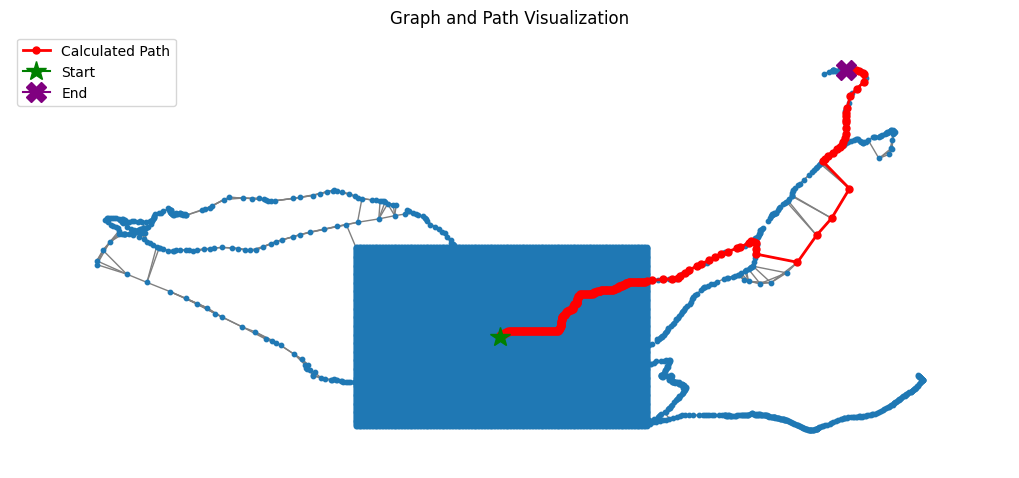

In [7]:
path = find_path(G, source=(51.99895007, -9.74338607), target=(52.025803, -9.7086641), weight=0.0)
node_positions = {node: (node[1], node[0]) for node in G.nodes()}

plt.figure(figsize=(10, 8))
nx.draw(G, pos=node_positions, with_labels=False, node_size=10, alpha=1.0, edge_color='gray')

path_nodes = path[0]
path_latitudes = [node[0] for node in path_nodes]
path_longitudes = [node[1] for node in path_nodes]
path_elevations = [G.nodes[node]["elevation"] for node in path_nodes]

plt.plot(path_longitudes, path_latitudes, color='red', linewidth=2, marker='o', markersize=5, label='Calculated Path')
if path_nodes:
  start_node = path_nodes[0]
  end_node = path_nodes[-1]
  plt.plot(start_node[1], start_node[0], marker='*', markersize=15, color='green', label='Start')
  plt.plot(end_node[1], end_node[0], marker='X', markersize=15, color='purple', label='End')

plt.title('Graph and Path Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()